<a href="https://colab.research.google.com/github/secutron/RNN-for-Human-Activity-Recognition-using-2D-Pose-Input/blob/master/demo_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%xmode Verbose
%pdb on

Exception reporting mode: Verbose
Automatic pdb calling has been turned ON


In [0]:
!git clone https://github.com/secutron/face_toolbox_keras.git
%cd face_toolbox_keras

Cloning into 'face_toolbox_keras'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 484 (delta 131), reused 23 (delta 11), pack-reused 230
Receiving objects: 100% (484/484), 247.75 MiB | 33.80 MiB/s, done.
Resolving deltas: 100% (235/235), done.
Checking out files: 100% (42/42), done.
/content/face_toolbox_keras


In [0]:
!gdown https://drive.google.com/uc?id=1H37LER8mRRI4q_nxpS3uQz3DcGHkTrNU
!mv lresnet100e_ir_keras.h5 ./models/verifier/insightface/lresnet100e_ir_keras.h5
!gdown https://drive.google.com/uc?id=18MyyXQIwhR5I6gzipYMiJ9ywgvFWQMvI
!mv backbone_ir50_ms1m_keras.h5 ./models/verifier/face_evoLVe_ir50/backbone_ir50_ms1m_keras.h5
!gdown https://drive.google.com/uc?id=1P_eQHU8bNJEsB6hHt_fnltOwQVKIfhiX
!mv backbone_ir50_asia_keras.h5 ./models/verifier/face_evoLVe_ir50/backbone_ir50_asia_keras.h5

Downloading...
From: https://drive.google.com/uc?id=1H37LER8mRRI4q_nxpS3uQz3DcGHkTrNU
To: /content/face_toolbox_keras/lresnet100e_ir_keras.h5
262MB [00:01, 167MB/s]
Downloading...
From: https://drive.google.com/uc?id=18MyyXQIwhR5I6gzipYMiJ9ywgvFWQMvI
To: /content/face_toolbox_keras/backbone_ir50_ms1m_keras.h5
175MB [00:01, 138MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1P_eQHU8bNJEsB6hHt_fnltOwQVKIfhiX
To: /content/face_toolbox_keras/backbone_ir50_asia_keras.h5
175MB [00:00, 190MB/s]


In [0]:
#!pip install keras==2.2.4

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

---

In [0]:
def resize_image(im, max_size=768):
    if np.max(im.shape) > max_size:
        ratio = max_size / np.max(im.shape)
        print(f"Resize image to ({str(int(im.shape[1]*ratio))}, {str(int(im.shape[0]*ratio))}).")
        return cv2.resize(im, (0,0), fx=ratio, fy=ratio)
    return im

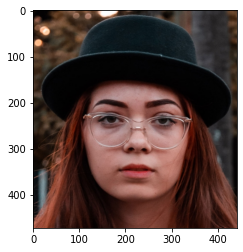

In [0]:
# Test images are obtained on https://www.pexels.com/
im = cv2.imread("images/test.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

---
# 0. Coordinate ordering

The coordinate in this demo has ordering `(x, y)`, which follows the format fo numpy array: `x` is the vertical axis and `y` the horizontal axis.

---
# 1. Face detection

Face deteciton using S3FD and FAN.

In [0]:
from models.detector import face_detector

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import initializers
iz = initializers.get('zeros')

2.2.0


In [0]:
fd = face_detector.FaceAlignmentDetector(
    lmd_weights_path="./models/detector/FAN/2DFAN-4_keras.h5"# 2DFAN-4_keras.h5, 2DFAN-1_keras.h5
)

NameError: ignored

> /content/face_toolbox_keras/models/detector/s3fd/model.py(13)__init__()
     11     def __init__(self, weights=None, axis=-1, gamma_init='zero', n_channels=256, scale=10, **kwargs):
     12         self.axis = axis
---> 13         self.gamma_init = initializers.get(gamma_init)
     14         self.initial_weights = weights
     15         self.n_channels = n_channels

ipdb> w
  <ipython-input-15-2abf23d1ef98>(2)<module>()
      1 fd = face_detector.FaceAlignmentDetector(
----> 2     lmd_weights_path="./models/detector/FAN/2DFAN-4_keras.h5"# 2DFAN-4_keras.h5, 2DFAN-1_keras.h5
      3 )

  /content/face_toolbox_keras/models/detector/face_detector.py(50)__init__()
     48         self.fd_type = fd_type.lower()
     49         if fd_type.lower() == "s3fd":
---> 50             self.fd = S3FaceDetector(fd_weights_path)
     51         elif fd_type.lower() == "mtcnn":
     52             self.fd = MTCNNFaceDetector()

  /content/face_toolbox_keras/models/detector/face_detector.py(34)__init_

## Detect faces

In [0]:
bboxes = fd.detect_face(im, with_landmarks=False)

In [0]:
assert len(bboxes) > 0, "No face detected."

# Display detected face
x0, y0, x1, y1, score = bboxes[0] # show the first detected face
x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])

plt.imshow(im[x0:x1, y0:y1, :])

## Detect faces and landmarks

`FaceDetector` will instantiate `FANLandmarksDetector` when calling `detect_face(with_landmarks=True)` the first time.

In [0]:
bboxes, landmarks = fd.detect_face(im, with_landmarks=True)

In [0]:
# Display landmarks
plt.figure(figsize=(15,8))
num_faces = len(bboxes)
for i in range(num_faces):
    try:
        plt.subplot(1, num_faces, i+1)
        plt.imshow(fd.draw_landmarks(im, landmarks[i], color=(0,255,0)))
    except:
        pass

---
# 2. Face parsing

Face parsing using BiSeNet.

In [0]:
from models.parser import face_parser

In [0]:
prs = face_parser.FaceParser()

## Parse without deteciton

In [0]:
out = prs.parse_face(im)

In [0]:
plt.imshow(out[0])

In [0]:
# Show parsing result with annotations

from utils.visualize import show_parsing_with_annos
show_parsing_with_annos(out[0])

## Parse with detection

Parsing network has its best performance on single face (even better if aligned).

In [0]:
im = cv2.imread("images/test2.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

In [0]:
# Set detector into FaceParser
try:
    fd
except:
    from detector import face_detector
    fd = face_detector.FaceAlignmentDetector()
    
prs.set_detector(fd)
# prs.remove_detector()

In [0]:
out = prs.parse_face(im, with_detection=True)

In [0]:
#plt.figure(figsize=(15,8))
num_faces = len(out)
for i in range(num_faces):
    try:
        plt.subplot(1, num_faces, i+1)
        plt.imshow(out[i])
    except:
        pass

---
# 3. Detect irises

Iris detection using ELG (Eye region Landmarks based Gaze estimation).

In [0]:
from models.detector.iris_detector import IrisDetector

## Detect iris, eyelibs and pulpils

In [0]:
im = cv2.imread("images/test5.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

In [0]:
idet = IrisDetector()

In [0]:
idet.set_detector(fd)

In [0]:
eye_lms = idet.detect_iris(im)

In [0]:
# Display detection result
plt.figure(figsize=(15,10))
draw = idet.draw_pupil(im, eye_lms[0][0,...]) # draw left eye
draw = idet.draw_pupil(draw, eye_lms[0][1,...]) # draw right eye
bboxes = fd.detect_face(im, with_landmarks=False)
x0, y0, x1, y1, _ = bboxes[0].astype(np.int32)
plt.subplot(1,2,1)
plt.imshow(draw)
plt.subplot(1,2,2)
plt.imshow(draw[x0:x1, y0:y1])

---
# 4. Face verification

Face verification using facenet.

In [0]:
from models.verifier.face_verifier import FaceVerifier

In [0]:
im1 = cv2.imread("images/test0.jpg")[..., ::-1]
im1 = resize_image(im1) # Resize image to prevent GPU OOM.
im2 = cv2.imread("images/BO1.jpg")[..., ::-1]
im2 = resize_image(im2) # Resize image to prevent GPU OOM.
im3 = cv2.imread("images/DT.jpg")[..., ::-1]
im3 = resize_image(im3) # Resize image to prevent GPU OOM.

In [0]:
fv = FaceVerifier(classes=512, extractor="facenet") # extractor="insightface"

In [0]:
fv.set_detector(fd)

## Verify if two given faces are the same person

In [0]:
# Face verification
result1, distance1 = fv.verify(im1, im2, threshold=0.5, with_detection=True, with_alignment=False, return_distance=True)
result2, distance2 = fv.verify(im1, im3, threshold=0.5, with_detection=True, with_alignment=False, return_distance=True)

In [0]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.title(f"Source face")
plt.imshow(im1)
plt.subplot(1,3,2)
plt.title(f"Same person: {str(result1)}\n Cosine distance: {str(round(distance1, 2))}")
plt.imshow(im2)
plt.subplot(1,3,3)
plt.title(f"Same person: {str(result2)}\n Cosine distance: {str(round(distance2, 2))}")
plt.imshow(im3)

---
# 5. Gender and Age Estimation

Gender/Age estimation using insightface mobilenet.

In [0]:
from models.estimator.gender_age_estimator import GenderAgeEstimator

In [0]:
im = cv2.imread("images/BO1.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

In [0]:
gae = GenderAgeEstimator(model_type="insightface")

In [0]:
gae.set_detector(fd)

In [0]:
gender, age = gae.predict_gender_age(im, with_detection=True)

In [0]:
print("Gender: female") if gender == 0 else print("Gender: male")
print(f"Age: {str(age)}")